In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
df = pd.read_csv('4year.csv')

C:\Users\Oshan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,5,6,7,9,10,13,14,15,16,17,21,23,24,25,28,33,34,35,37,47,49,50,56,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
target_frequency = df['class'].value_counts().rename("frequency")
target_proportion = df['class'].value_counts(normalize=True).rename("proportion")
pd.concat([target_frequency, target_proportion], axis=1)

,frequency,proportion
0,9277,0.95
1,515,0.05


## Class imbalance
only 5% of the total companies are default in the dataset so that there is a heavy class imbalance in out dataset. 
if we just apply a native model for this case we would get 90+ % accuracy. But such model would not be useful for predicting credti risk of a company.

## Feature Selection
For the feature selection we will apply one way  ANOVA F-test to each attribute to determine whether there is a statistically significant defference begtween the feature means of bankrupt vs non-bankrupt companies.

link - https://en.wikipedia.org/wiki/Point-biserial_correlation_coefficient

In [4]:
from sklearn.feature_selection import f_classif

In [5]:
feature_columns=[col for col in df.columns if col !="class"]

for item in feature_columns:
    df[item]=df[item].astype('str')
    df[item]=df[item].apply(lambda x: x.replace('?', '0')).astype('float')

X = df[feature_columns]
y = df['class']


In [6]:
F, pval = f_classif(X.fillna(0),y)

In [7]:
pval_series = pd.Series(pval, index=X.columns)
pval_threshold = 0.01

In [8]:
best_features = pval_series[pval_series<pval_threshold].sort_values()
print(f"There are {len(best_features)} features with p-value less than {pval_threshold}: \n{best_features}")

There are 14 features with p-value less than 0.01: 
Attr1    0.00
Attr35   0.00
Attr29   0.00
Attr14   0.00
Attr7    0.00
Attr11   0.00
Attr22   0.00
Attr56   0.00
Attr39   0.00
Attr18   0.00
Attr12   0.00
Attr26   0.00
Attr16   0.00
Attr48   0.00
dtype: float64


<AxesSubplot:>

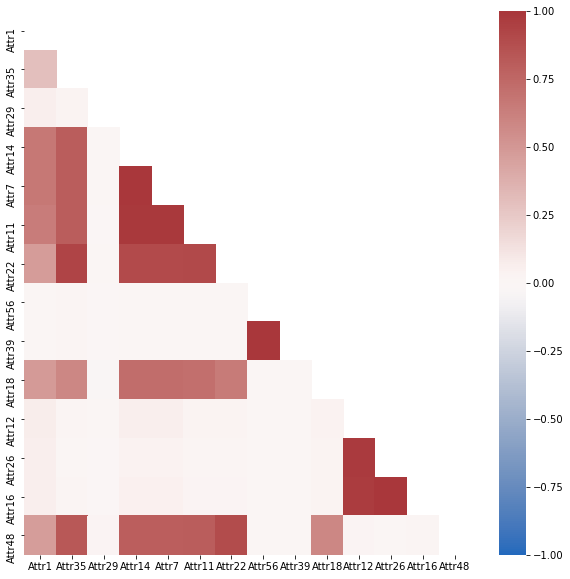

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
corr_df = X[best_features.index].corr(method="pearson")
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df, cmap="vlag", vmin=-1, vmax=1, mask=mask, ax=ax)

## Data Visualization
From our selcted features we should be able to see a highlighted difference of value between bankrupt companies and non-bankrupt companies.

ex :- lower return on asset, lower solvency ratio and lower profit margin for bankrupt companies

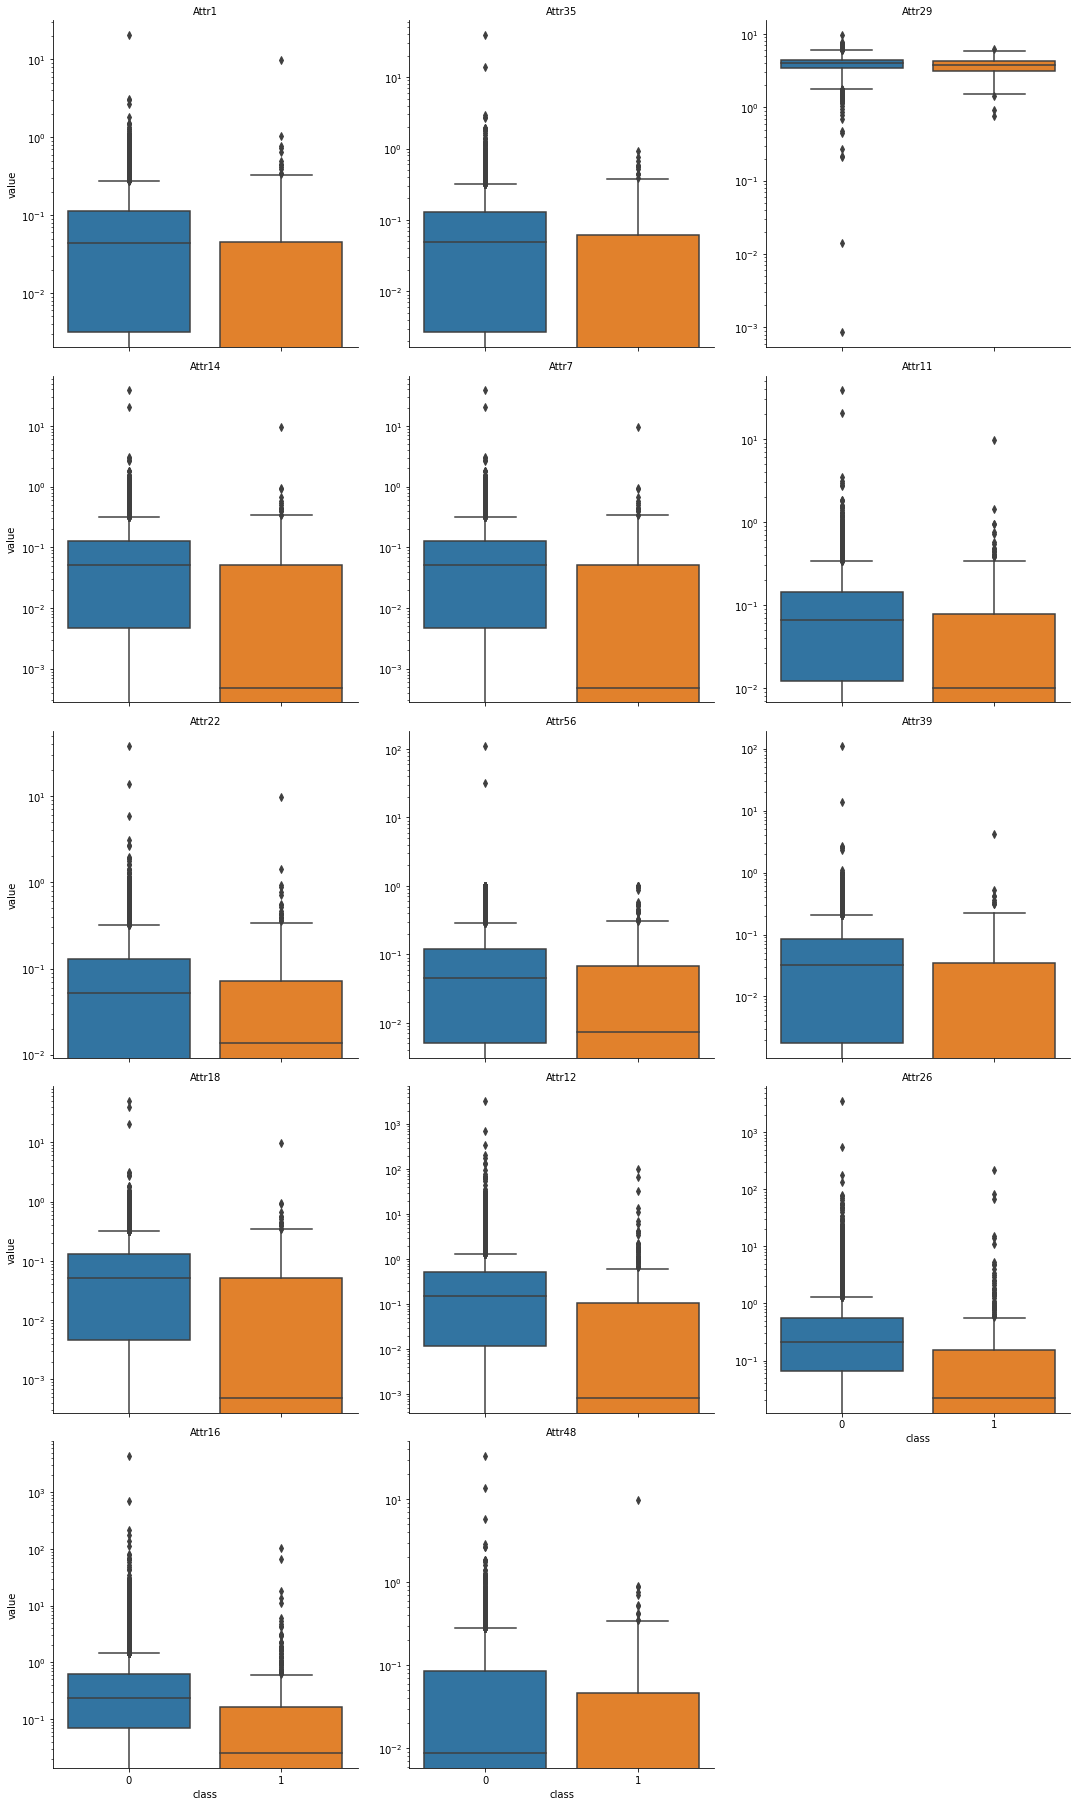

In [10]:
cols = best_features.index.to_list() + ["class"]
melted_df = df[cols].reset_index().melt(id_vars=["index", "class"])

g = sns.catplot(data=melted_df, x="class", y="value", col="variable", kind="box", col_wrap=3, sharey=False)
g.set_titles(col_template="{col_name}")

# plot in logarithmic scale as there are a few companies with extremely large values 
for ax in g.axes.flatten():
    if ax.get_title() != "logarithm of total assets":
        ax.set_yscale('log')

# Implimentation of model

In [11]:
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_validate

In [12]:
for item in df:
    if item not in cols:
        del df[item]

In [13]:
Y = df["class"]
X = df.drop(["class"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=y, random_state=0)

In [14]:
print(f"Positive class samples in train set: {np.bincount(y_train)[1]}")
print(f"Positive class samples in test set: {np.bincount(y_test)[1]} \n")

# 3-fold cross validation
stratified_cv = StratifiedKFold(n_splits=3)
for (train, validation) , sequence in zip(stratified_cv.split(X_train, y_train), ("first", "second", "third")):
    print(f"Positive class samples in {sequence} validation fold: {np.bincount(y_train.iloc[validation])[1]}")

Positive class samples in train set: 412
Positive class samples in test set: 103 

Positive class samples in first validation fold: 137
Positive class samples in second validation fold: 137
Positive class samples in third validation fold: 138


In [15]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

print(f"Before resampling: \n{y_train.value_counts()}")

ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print(f"\nAfter oversampling: \n{y_ros.value_counts()}")

rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_resample(X_train, y_train)
print(f"\nAfter undersampling: \n{y_rus.value_counts()}")

Before resampling: 
0    7421
1     412
Name: class, dtype: int64

After oversampling: 
1    7421
0    7421
Name: class, dtype: int64

After undersampling: 
1    412
0    412
Name: class, dtype: int64


In [16]:
from sklearn.metrics import fbeta_score, make_scorer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier

In [17]:
scaler = RobustScaler()
rf = RandomForestClassifier(n_estimators=200)

def evaluate_pipeline(pipeline, X_train, y_train, cv):
    """
    Run cross validation for the input pipeline and returns the average precision, recall and F-beta score.
    """
    cv_metrics = cross_validate(pipeline, X_train, y_train, cv=cv, scoring={"precision":"precision", "recall":"recall", "fbeta":make_scorer(fbeta_score, beta=2)})
    cv_metrics_df = pd.DataFrame(cv_metrics)
    average_cv_metrics = cv_metrics_df[["test_precision", "test_recall", "test_fbeta"]].mean()
    return average_cv_metrics

# oversampling
oversampling_pipeline = Pipeline([('ros', ros), ('scaler', scaler), ("classifier", rf)])
oversampling_metrics = evaluate_pipeline(oversampling_pipeline, X_train, y_train, stratified_cv)
print(f"Metrics with random oversampling: \n{oversampling_metrics}\n")

# undersampling
undersampling_pipeline = Pipeline([('rus', rus), ('scaler', scaler), ("classifier", rf)])
undersampling_metrics = evaluate_pipeline(undersampling_pipeline, X_train, y_train, stratified_cv)
print(f"Metrics with random undersampling: \n{undersampling_metrics}")

Metrics with random oversampling: 
test_precision   0.26
test_recall      0.06
test_fbeta       0.07
dtype: float64

Metrics with random undersampling: 
test_precision   0.11
test_recall      0.70
test_fbeta       0.34
dtype: float64


<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

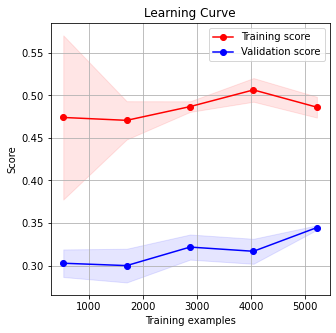

In [18]:
from diagnosis import plot_learning_curve

plot_learning_curve(undersampling_pipeline, X_train, y_train, stratified_cv, make_scorer(fbeta_score, beta=2))

As you can see in the figure model is underfited but we hope to improve the model using feature engineering methods

In [31]:
df_updated = pd.read_csv('4year.csv')

for item in feature_columns:
    df_updated[item]=df_updated[item].astype('str')
    df_updated[item]=df_updated[item].apply(lambda x: x.replace('?', '0')).astype('float')

feature_cols = [col for col in df_updated.columns if col not in ("class", "index")]

X = df_updated[feature_cols]
X.shape

C:\Users\Oshan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,1,2,5,6,7,9,10,13,14,15,16,17,21,23,24,25,28,33,34,35,37,47,49,50,56,58) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(9792, 64)

In [36]:
col1 = 'Attr23'
col2 = 'Attr53'

X.loc[X[col1].isna(), col2].all() == 0

False

In [34]:
col = 'Attr25' 
X[col].fillna(X[col].max(), inplace=True)

C:\Users\Oshan\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [28]:

# rows with more than 10 missing values
more_than_10_missing = df_updated[df_updated.isnull().sum(axis=1) > 10]
print(f"There are {len(more_than_10_missing)} rows with more than 10 missing values")

more_than_10_missing["class"].value_counts()

There are 0 rows with more than 10 missing values


Series([], Name: class, dtype: int64)

In [29]:
feature_cols = [col for col in df_updated.columns if col not in ("class", "index")]

combined_X = df_updated[feature_cols]
combined_X.shape

(9792, 64)